# Jupyter Notebook

## Step 1: Configuration de l’environnement 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import re

# Create a SparkSession
spark = SparkSession.builder \
    .appName("demo-app") \
    .enableHiveSupport() \
    .getOrCreate()

## Step 2: Transformation des données avec Spark 

In [5]:
# Read the data from Hadoop
df = spark.read.format("csv").option("header", "true").load("hdfs://namenode:9000/data/demo.csv")

print(df)

DataFrame[name: string, age: string, city: string]


In [15]:
# Define a UDF to clean the data
def clean_data(s):
    # Remove all non-alphabetic characters
    s = re.sub(r'[^a-zA-Z,]', '', s)
    # Remove all extra spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

clean_data_udf = udf(clean_data)

# Assuming df is your DataFrame and 'column_to_clean' is the column you want to clean
df_clean = df.withColumn('clean_data', clean_data_udf(df['name']))

df_clean = df_clean.withColumn("age",  
                                df_clean["age"] 
                                .cast('int')) 
df_clean.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- clean_data: string (nullable = true)



In [16]:
# Perform a simple transformation
transformed_df = df_clean.filter(df.age > 18)

print(transformed_df)

DataFrame[name: string, age: int, city: string, clean_data: string]


## Step 3: Stockage des données transformées dans Hive 

In [17]:
# Write the transformed DataFrame to Hive
transformed_df.write.mode("overwrite").saveAsTable("adulte")

## Step 4: Interrogation des données avec SQL  

In [18]:
# Query the data from Hive
result = spark.sql("SELECT * FROM adulte LIMIT 10")

# Show the result
result.show()

+-----+---+--------+----------+
| name|age|    city|clean_data|
+-----+---+--------+----------+
| John| 23|New York|      John|
| Anna| 45|  London|      Anna|
|Peter| 36|   Paris|     Peter|
|Barry| 27|   Dakar|     Barry|
|Linda| 78|  Berlin|     Linda|
|  Tom| 22|  Sydney|       Tom|
+-----+---+--------+----------+



## Step 5: Visualisation des données 

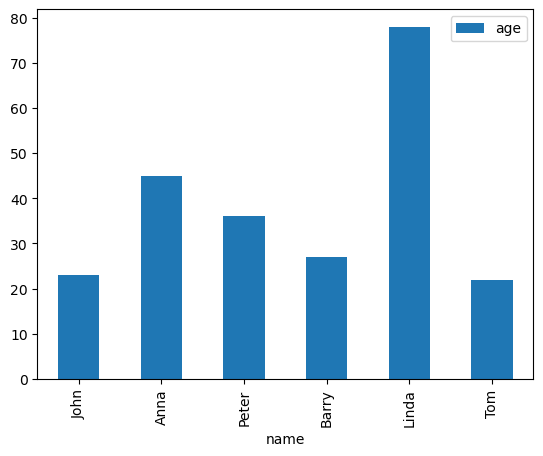

In [19]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
result_pd = result.toPandas()

# Plot the data
result_pd.plot(kind='bar', x='name', y='age')
plt.show()

## Step 6 : Fermer SparkSession

In [20]:
spark.stop()